In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torchaudio
import torch
from transformers import pipeline
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import IPython.display as ipd
import os
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
PATH = "/kaggle/input/cremad/AudioWAV"
dir_list = os.listdir(PATH) 
dir_list.sort()

**Data processing**

First, we read the dataset and organize the labels and paths of the audio files in a dataframe.

In [3]:
labels = []
path = []
for i in dir_list:
    path.append(PATH + '/' + i)
    if 'ANG' in i:
        labels.append('angry')
    elif 'DIS' in i:
        labels.append('disgust')
    elif 'FEA' in i:
        labels.append('fear')
    elif 'HAP' in i:
        labels.append('happy')
    elif 'NEU' in i:
        labels.append('neutral')
    elif 'SAD' in i:
        labels.append('sad')
    else:
        labels.append('unknown')

emotion_df = pd.DataFrame(labels, columns=['Emotions'])

path_df = pd.DataFrame(path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)

In order to check the data we display the first audio.

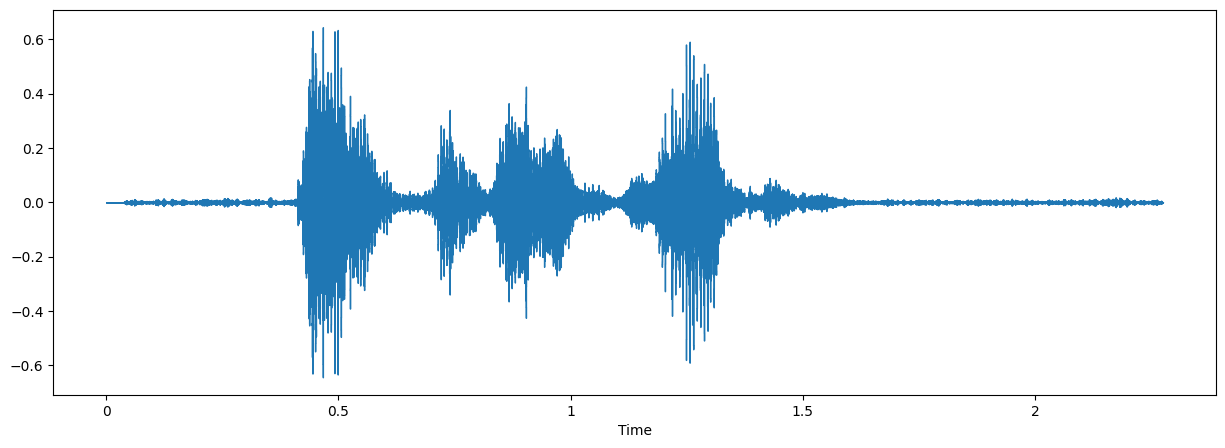

In [4]:
audio , sampling_rate = librosa.load(crema_df['Path'][0])
plt.figure(figsize=(15,5))
librosa.display.waveshow(audio , sr = sampling_rate)
ipd.Audio(crema_df['Path'][0])

Before extracting the MFCC features for all of the audios we wanted to see how they look visually for different emotions of the same sentence.

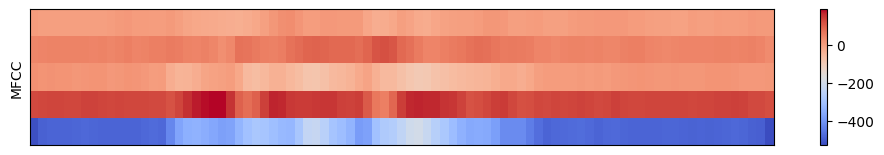

In [5]:
SAMPLE_RATE = 22050
v_path = '/kaggle/input/cremad/AudioWAV/1001_DFA_SAD_XX.wav'
audio , sampling_rate = librosa.load(v_path,sr=SAMPLE_RATE)
mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc = 5)
plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()
plt.show()

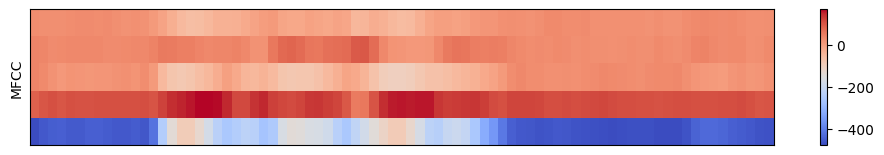

In [6]:
SAMPLE_RATE = 22050
v_path = '/kaggle/input/cremad/AudioWAV/1001_DFA_HAP_XX.wav'
audio , sampling_rate = librosa.load(v_path,sr=SAMPLE_RATE)
mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc = 5)
plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()
plt.show()

Based on this we can see that there are differences in the MFCC features of all the audios, but there are also some similarities and overlapping.

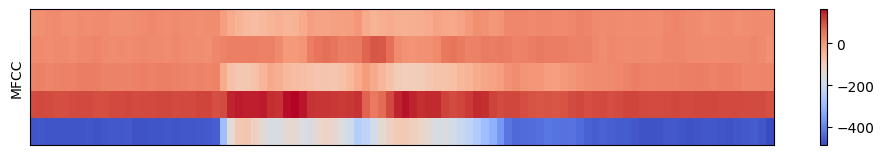

In [7]:
SAMPLE_RATE = 22050
v_path = '/kaggle/input/cremad/AudioWAV/1001_DFA_FEA_XX.wav'
audio , sampling_rate = librosa.load(v_path,sr=SAMPLE_RATE)
mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc = 5)
plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()
plt.show()

In [8]:
crema_df['Emotions'] = crema_df['Emotions'].astype(str)

**Generating the MFCC features**

For each audio we generate their MFCC features and organize them into a dataframe with the label for each emotion.

In [9]:
labels = {'disgust':0,'happy':1,'sad':2,'neutral':3,'fear':4,'angry':5}
crema_df.replace({'Emotions':labels},inplace=True)
num_mfcc = 13
n_fft = 2048
hop_length = 512
SAMPLE_RATE = 22050
data = {
    "labels": [],
    "mfcc": []
}

for i in range(7442):
    data['labels'].append(crema_df.iloc[i, 0])
    signal, sample_rate = librosa.load(crema_df.iloc[i, 1], sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T
    data["mfcc"].append(np.asarray(mfcc))
    if i % 500 == 0:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


In [10]:
import tensorflow as tf

We make sure each row has the same size by padding the MFCC features so they all have the same size (216).

In [11]:
X = np.asarray(data['mfcc'], dtype="object")
y = np.asarray(data["labels"], dtype="object")
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(7442, 216, 13)

**Splitting the data for training, testing and validation**

We splitted the data into 12% for training and then split the remaining 88% training data using 30% for validation.

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [13]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

In [14]:
X_train.shape

(625, 216, 13)

**Implementing an LSTM model**

Implemented a sequential LSTM using 3 layers:

* LSTM layer with 64 units and return_sequences=True
* LSTM layer with 64 units
* Dense layer with 6 units and softmax activation

In [15]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks
MODEL = Sequential()
MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dense(6, activation='softmax'))

print(MODEL.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 216, 64)           19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 53382 (208.52 KB)
Trainable params: 53382 (208.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [16]:
#rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
model = MODEL.fit(X_train, y_train_class, epochs=200, batch_size=6, validation_data=(X_val, y_val_class))

Epoch 1/200
105/105 [==============================] - 11s 26ms/step - loss: 1.6388 - categorical_accuracy: 0.2960 - val_loss: 1.5227 - val_categorical_accuracy: 0.3457
Epoch 2/200
105/105 [==============================] - 2s 16ms/step - loss: 1.5210 - categorical_accuracy: 0.3696 - val_loss: 1.4696 - val_categorical_accuracy: 0.3829
Epoch 3/200
105/105 [==============================] - 2s 16ms/step - loss: 1.4680 - categorical_accuracy: 0.3808 - val_loss: 1.5140 - val_categorical_accuracy: 0.3866
Epoch 4/200
105/105 [==============================] - 2s 15ms/step - loss: 1.4377 - categorical_accuracy: 0.4080 - val_loss: 1.5645 - val_categorical_accuracy: 0.3680
Epoch 5/200
105/105 [==============================] - 2s 16ms/step - loss: 1.4234 - categorical_accuracy: 0.3968 - val_loss: 1.5464 - val_categorical_accuracy: 0.3346
Epoch 6/200
105/105 [==============================] - 2s 16ms/step - loss: 1.3840 - categorical_accuracy: 0.4304 - val_loss: 1.4386 - val_categorical_accuracy

**Model results**

Calculated loss and accuracy for each epoch during training and validation.

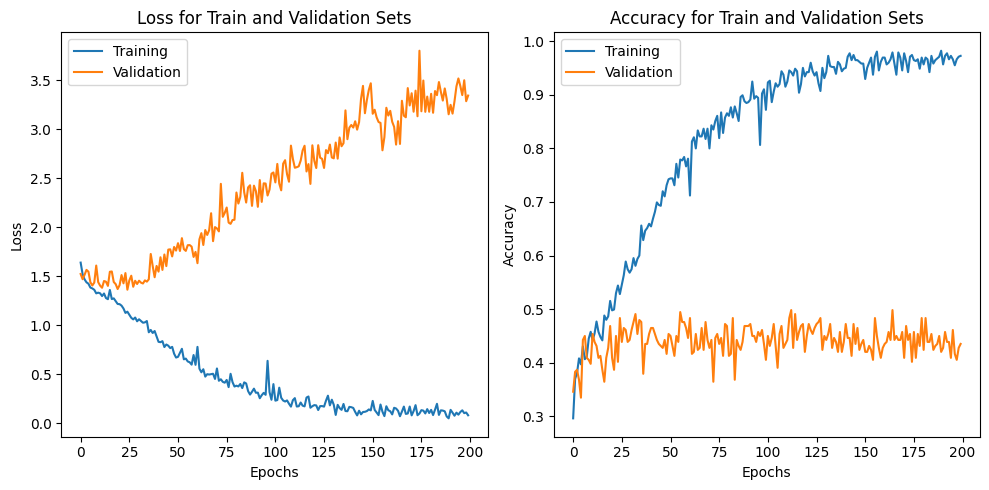

In [17]:
from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model.history['loss'])
axes[0].plot(model.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model.history['categorical_accuracy'])
axes[1].plot(model.history['val_categorical_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

9/9 [==============================] - 1s 12ms/step


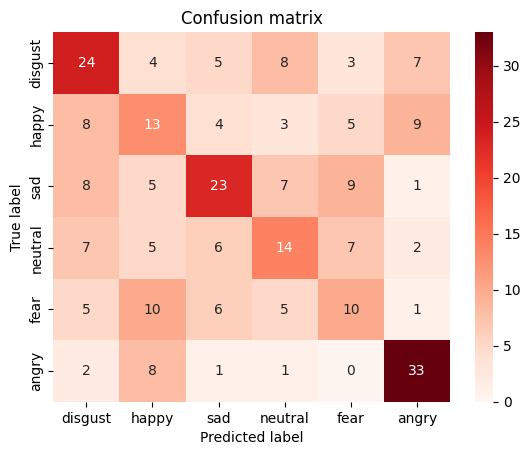

In [18]:
import seaborn as sns

y_pred = np.argmax(MODEL.predict(X_val), axis=1) 
# ['disgust','happy','sad','neutral','fear','angry']
labels = ['disgust','happy','sad','neutral','fear','angry']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [19]:
from sklearn.metrics import classification_report
# Make predictions on test set
#Y_pred = MODEL.predict(X_val)
#Y_pred = [np.argmax(i) for i in Y_pred]
# Print the metrics
print(classification_report(np.argmax(y_val_class, axis=1),y_pred))

              precision    recall  f1-score   support

           0       0.44      0.47      0.46        51
           1       0.29      0.31      0.30        42
           2       0.51      0.43      0.47        53
           3       0.37      0.34      0.35        41
           4       0.29      0.27      0.28        37
           5       0.62      0.73      0.67        45

    accuracy                           0.43       269
   macro avg       0.42      0.43      0.42       269
weighted avg       0.43      0.43      0.43       269

